In [1]:
import sys
sys.path.append("../..")

#Defining libraries
import os
import pandas as pd
import numpy as np
import rasterio
from collections import defaultdict
import glob


In [2]:
'''
1-11-> Residential urban areas 
2-121,13->Industrial and abbandoned urban areas
3-122,123,124 Transportation infrastructure (streets, highways, airports, and ports)
4-14->Urban green areas
5-2->Agricultural areas
6-3->Forest
7-4/5->Hydro and humid bodies
'''
#Convert from copernicus code 2018 to an internal code
URBAN = 1
INDUSTRIAL = 2
TRANSPORTATION = 3
URBAN_VEGETATION = 4
RURAL = 5
FOREST = 6
WATER = 7
LC_NO_DATA = 9999
NO_DATA= -9999
    
# Function to check if the file is a tiff and must be read.
def check_wrong_files(f):
    if f == 'clip': return True #avoid entering the "clip" folder
    if 'csv'in f: return True
    if f in ['2017']: return True #Not consider the 2017 image as it biases the model
    if 'ipynb' in f: return True #avoid entering the "ipynb_checkpoint" file
    if 'tar' in f: return True #avoid entering "tar" files
    if 'aux' in f: return True #avoid entering "aux" files
    return False

def match_landsat_to_landcover(landsat):
    year = int(landsat)
    if year in [2015,2016]:
        return str(2015)
    elif year in [2017,2018,2019]:
        return str(2018)
    elif year in [2020,2021,2022]:
        return str(2021)

In [3]:
# City parameters and global variables
city_info = {
    "resolution": 5,
    "epsg": 32632,
    "capitalized": "Milan"
}

city = 'MILANO'
current_city_info = city_info
city_epsg = current_city_info['epsg']
data_folder = "data"
#landcover_path = f'{landcover_base_path}/DUSAF_MCM_mapped_{year}.tif'

landsat_raster_folder = "/home/user/ODC_harmonia/Landsat/Milan/data"
sat_images_path = f"{landsat_raster_folder}/clip"
file_list = os.listdir(f"{sat_images_path}")
landcover_base_path = f'{data_folder}/landcover'
#landsat_raster_file_list = os.listdir(f"{landsat_raster_folder}")

total_samples_per_raster = 30000


## Mosaicing LST, NDVI, NDBI, and albedo per year

To be run only if summer mosaics are unavailable.

In [ ]:
# Define raster types
raster_types = ["LST", "NDVI", "NDBI", "albedo"]

# Group rasters by year
rasters_by_year = {}

# Extract year from folder names and organize rasters
for folder in file_list:
    if folder.startswith("LC08_L2SP"):
        year = folder.split("_")[3][:4]
        if year not in rasters_by_year:
            rasters_by_year[year] = {}
        folder_path = os.path.join(sat_images_path, folder)
        for raster_type in raster_types:
            if raster_type not in rasters_by_year[year]:
                rasters_by_year[year][raster_type] = []
            raster_files = glob.glob(os.path.join(folder_path, f"*{folder}_{raster_type}*.TIF"))
            rasters_by_year[year][raster_type].extend(raster_files)

In [48]:
output_dir = f"{landsat_raster_folder}/summer_avg"
os.makedirs(output_dir, exist_ok=True)

In [49]:
def compute_yearly_mosaic(raster_files, output_path):
    if not raster_files:
        print(f"No files found for {output_path}")
        return

    datasets = [rasterio.open(fp) for fp in raster_files]
    meta = datasets[0].meta
    meta.update(dtype=rasterio.float32, compress='lzw')  # Ensure float32 output

    # Read and stack rasters
    data_stack = np.array([ds.read(1) for ds in datasets])

    # Mask invalid values (-9999) with NaN for proper averaging
    data_stack = np.where(data_stack == -9999, np.nan, data_stack)

    # Compute mosaic: per-pixel mean of valid values (ignoring NaNs)
    mosaic_raster = np.nanmean(data_stack, axis=0)

    # Replace remaining NaNs (if a pixel is invalid in all rasters) with -9999
    mosaic_raster = np.where(np.isnan(mosaic_raster), -9999, mosaic_raster)

    # Save output raster
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(mosaic_raster.astype(np.float32), 1)

    # Close datasets
    for ds in datasets:
        ds.close()

In [50]:
for year, raster_dict in rasters_by_year.items():
    year_dir = os.path.join(output_dir, year)  # Create a folder for each year
    os.makedirs(year_dir, exist_ok=True)  # Ensure the directory exists

    for raster_type, files in raster_dict.items():
        output_path = os.path.join(year_dir, f"{raster_type}_{year}.tif")
        compute_yearly_mosaic(files, output_path)
        print(f"Saved: {output_path}")


/tmp/ipykernel_70819/3734086624.py:18: RuntimeWarning: Mean of empty slice
  mosaic_raster = np.nanmean(data_stack, axis=0)


Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2018/LST_2018.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2018/NDVI_2018.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2018/NDBI_2018.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2018/albedo_2018.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2019/LST_2019.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2019/NDVI_2019.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2019/NDBI_2019.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2019/albedo_2019.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2015/LST_2015.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2015/NDVI_2015.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2015/NDBI_2015.tif
Saved: /home/user/ODC_harmonia/Landsat/Milan/data/summer_avg/2015/albedo_2015.tif
Saved: /home/user/ODC_harmonia/Landsa

## Build new UHI and UHII based on summer mosaics

To be run only once to get UHI and UHII maps

In [5]:
# Create an empty DataFrame to store all scenes' information
all_scenes_df = pd.DataFrame(columns=['scene', 'landcover_class', 'avg_temp', 'min_temp', 'max_temp', 'std_temp'])

lst_folder = f"{landsat_raster_folder}/summer_avg"
lst_file_list = os.listdir(f"{lst_folder}")

for f in lst_file_list:
    if check_wrong_files(f): continue

    try:
        year = str(f)
        landcover_year = match_landsat_to_landcover(f)
        landcover_path = f'{landcover_base_path}/DUSAF_{landcover_year}_MCM_mapped.tif'

        print(f'Processing for {city}')
        with rasterio.open(landcover_path, driver="GTiff") as lancover_raster:
            landcover_array = lancover_raster.read(1)
            #print(lancover_raster.profile)
            rows, cols = landcover_array.shape
            x_positions = np.arange(0, cols)
            y_positions = np.arange(0, rows)
            x, y = np.meshgrid(x_positions, y_positions)
            x_flat = x.flatten()
            y_flat = y.flatten()
            values_flat = landcover_array.flatten()

        # Create a DataFrame for the Landcover 
        landcover_df = pd.DataFrame({'x': x_flat, 'y': y_flat, 'landcover': values_flat})
        landcover_df['landcover'] = landcover_df['landcover']

        print(f'Processing {f}')
        lst_path = f"{lst_folder}/{f}/LST_{year}.tif"
        with rasterio.open(lst_path, driver="GTiff") as lst_raster:
            lst_array = lst_raster.read(1)
            #print(lst_raster.profile)
            rows, cols = landcover_array.shape
            x_positions = np.arange(0, cols)
            y_positions = np.arange(0, rows)
            x, y = np.meshgrid(x_positions, y_positions)
            x_flat = x.flatten()
            y_flat = y.flatten()
            values_flat = lst_array.flatten()

            # Create a DataFrame for the lst
            lst_df = pd.DataFrame({'x': x_flat, 'y': y_flat, 'lst': values_flat})
            lst_df['landcover'] =  landcover_df.copy()['landcover']

            lst_df = lst_df.loc[
                (lst_df['landcover'] != LC_NO_DATA) & (lst_df['lst'] > 273) & (lst_df['lst'] != NO_DATA)
            ]
            #Remove URBAN_VEGETATION bc reference temperature is only rural
            rural_mean = lst_df.loc[
                (lst_df['landcover'] == RURAL) | (lst_df['landcover'] == FOREST)
            ]['lst'].mean()
            print(rural_mean)

             # Compute the average, min, max, and std temperature per land cover class
            stats_per_class = lst_df.groupby('landcover')['lst'].agg(
                mean='mean', 
                min='min', 
                max='max', 
                std='std', 
                q1=lambda x: np.percentile(x, 25), 
                q3=lambda x: np.percentile(x, 75)
            ).reset_index()
            
            stats_per_class['scene'] = year  # Add the scene name/identifier (can be year or file name)
            
            # Rename columns for clarity
            stats_per_class.columns = ['landcover_class', 'avg_temp', 'min_temp', 'max_temp', 'std_temp', 'q1_temp', 'q3_temp', 'scene']


            # Append the results to the all_scenes_df
            all_scenes_df = pd.concat([all_scenes_df, stats_per_class])
            
            #Compute UHI binary maps
            uhi_raster = np.where((lst_array > 273) & (lst_array != NO_DATA), (lst_array > rural_mean).astype('int16'), -9999) #setting nodata from LST
            uhi_raster = np.where(landcover_array != LC_NO_DATA, uhi_raster, -9999) #setting nodata from landcover
            uhi_raster = np.where(landcover_array != WATER, uhi_raster, -9999) #setting the water as nodata

            uhi_meta = lst_raster.profile.copy()
            uhi_meta['dtype'] = np.int16
            uhi_meta['nodata'] = -9999

            uhi_raster_path = f"{lst_folder}/{f}/uhi_{year}.tif"
            with rasterio.open(uhi_raster_path, 'w', **uhi_meta) as dest:
                dest.write(uhi_raster, 1)
                
                
            #Compute UHI Intensity
            uhii_raster = np.where((lst_array > 273) & (lst_array != NO_DATA), lst_array - rural_mean, -9999) #setting nodata from LST
            uhii_raster = np.where(landcover_array != LC_NO_DATA, uhii_raster, -9999) #setting nodata from landcover
            uhii_raster = np.where(landcover_array != WATER, uhii_raster, -9999) #setting the water as nodata

            uhii_meta = lst_raster.profile.copy()
            uhii_meta['dtype'] = np.float32
            uhii_meta['nodata'] = -9999

            uhii_raster_path = f"{lst_folder}/{f}/uhi_int_{year}.tif"
            with rasterio.open(uhii_raster_path, 'w', **uhii_meta) as dest:
                dest.write(uhii_raster, 1)
    except Exception as e: 
        print(e)    

Processing for MILANO
Processing 2016
307.7191
Processing for MILANO
Processing 2021
309.67303
Processing for MILANO
Processing 2022
315.65848
Processing for MILANO
Processing 2015
311.55902
Processing for MILANO
Processing 2019
307.92105
Processing for MILANO
Processing 2020
306.45474
Processing for MILANO
Processing 2018
307.19537


In [58]:
all_scenes_df

,scene,landcover_class,avg_temp,min_temp,max_temp,std_temp,q1_temp,q3_temp
0,2016,1,313.885468,300.358459,325.962860,2.284621,312.601807,315.491760
1,2016,2,314.598602,297.789856,331.713684,3.423570,312.400146,316.857239
2,2016,3,313.673920,302.340912,325.352722,2.973420,311.624268,315.703674
3,2016,4,311.339081,301.435150,323.507019,2.774362,309.460663,313.292236
4,2016,5,307.937439,300.112366,325.791962,2.653560,305.840973,309.744354
...,...,...,...,...,...,...,...,...
3,2018,4,312.937225,292.553436,327.116455,3.326754,310.983398,315.190979
4,2018,5,307.460938,291.893738,324.089783,4.014516,304.926636,310.120331
5,2018,6,305.554657,291.018738,324.175232,5.112056,301.843597,309.282898
6,2018,7,305.847137,291.432312,319.219116,3.774375,304.068726,307.900330


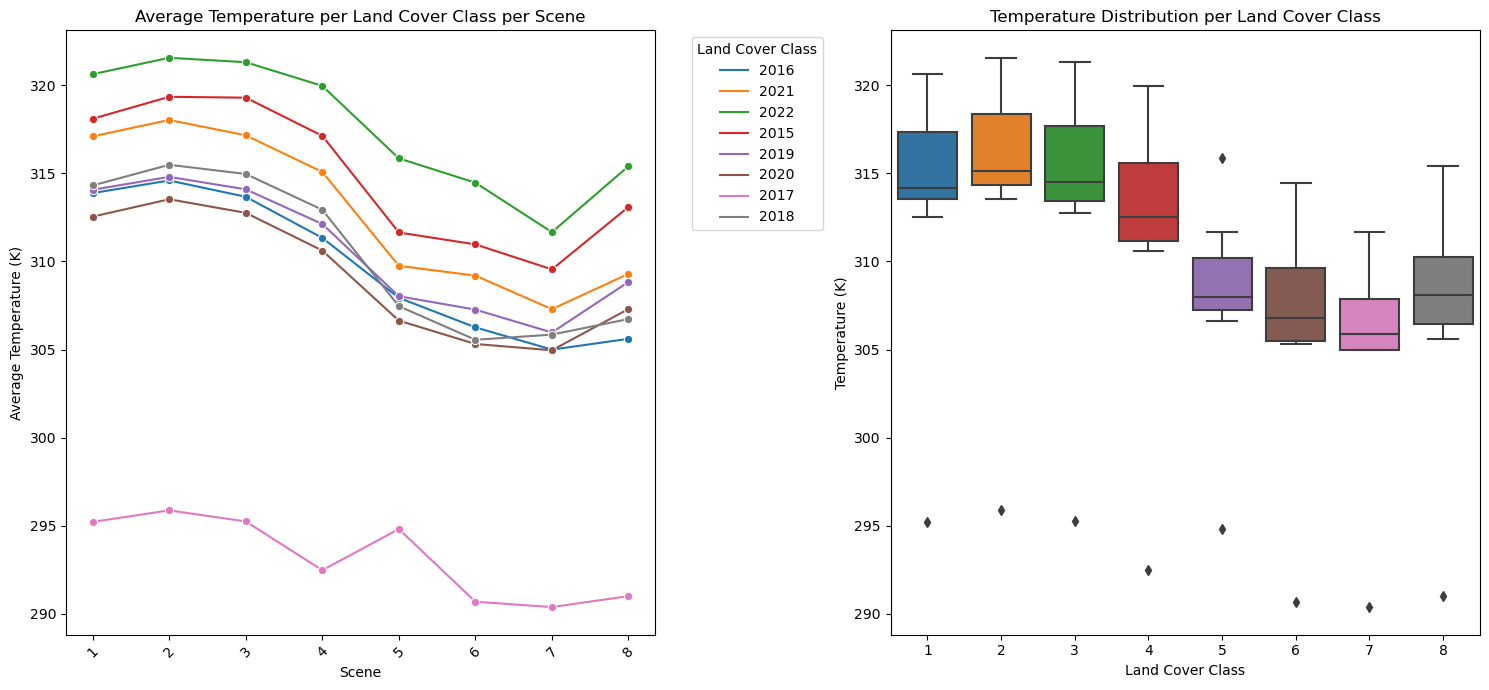

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `all_scenes_df` is your DataFrame with the computed stats
# First, ensure the scene column is treated as categorical for better plotting
all_scenes_df['scene'] = pd.Categorical(all_scenes_df['scene'], categories=all_scenes_df['scene'].unique(), ordered=True)

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# --- Linear Plot (Average Temperature per Land Cover Class per Scene) ---
sns.lineplot(x='landcover_class', y='avg_temp', hue='scene', data=all_scenes_df, ax=axes[0], marker='o')
axes[0].set_title('Average Temperature per Land Cover Class per Scene')
axes[0].set_xlabel('Scene')
axes[0].set_ylabel('Average Temperature (K)')
axes[0].legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)

# --- Box Plot (Distribution of Temperature per Land Cover Class) ---
sns.boxplot(x='landcover_class', y='avg_temp', data=all_scenes_df, ax=axes[1])
axes[1].set_title('Temperature Distribution per Land Cover Class')
axes[1].set_xlabel('Land Cover Class')
axes[1].set_ylabel('Temperature (K)')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [60]:
# Save the complete dataframe to a CSV file for later use
all_scenes_df.to_csv(f'{lst_folder}/all_scenes_summer_avg_temp_stats_per_class.csv', index=False)

## Sample based on summer mosaics

In [62]:
lst_file_list

['2016', '2021', '2022', '2015', '2019', '2020', '2017', '2018']

In [6]:
samples = pd.DataFrame()
predict_n= None
sample_n = [
    int(total_samples_per_raster / 4),  # urban, uhi 1
    int(total_samples_per_raster / 4),  # urban, uhi 0
    int(total_samples_per_raster / 4),  # rural/vegetation/bareland, uhi 1
    int(total_samples_per_raster / 4),  # rural/vegetation/bareland, uhi 0
]
all_samples = []

for f in lst_file_list:
    if check_wrong_files(f):
        continue

    print(f'Processing {f}')
    year = int(f)
    landcover_year = match_landsat_to_landcover(f)
    landcover_path = f'{landcover_base_path}/DUSAF_{landcover_year}_MCM_mapped.tif'
    print(landcover_path)
    
    with rasterio.open(landcover_path, driver="GTiff") as landcover_raster:
        landcover_array = landcover_raster.read(1)
        print('Read land cover')

    # Initialize prediction arrays on first iteration
    if not isinstance(predict_n,np.ndarray) and year >= 2020:
        predict_n = np.zeros_like(landcover_array, dtype=int)
        predict_lst = np.zeros_like(landcover_array, dtype=float)
        predict_ndvi = np.zeros_like(landcover_array, dtype=float)
        predict_ndbi = np.zeros_like(landcover_array, dtype=float)
        predict_albedo = np.zeros_like(landcover_array, dtype=float)

    # Load Landsat-derived rasters
    #add the uhi column
    with rasterio.open(f"{lst_folder}/{f}/uhi_{year}.tif", driver="GTiff") as uhi_raster:
        print('read UHI')
        uhi_array = uhi_raster.read(1) #UHI band

    #add the uhi intensity column
    #Uncomment to switch to UHI Intensity instead of UHI binary
    
    with rasterio.open(f"{lst_folder}/{f}/uhi_int_{year}.tif", driver="GTiff") as uhii_raster:
        print('read UHII')
        uhii_array = uhii_raster.read(1) #UHI band
        
    with rasterio.open(f"{lst_folder}/{f}/NDVI_{year}.tif", driver="GTiff") as ndvi_raster:
        ndvi_array = ndvi_raster.read(1)

    with rasterio.open(f"{lst_folder}/{f}/NDBI_{year}.tif", driver="GTiff") as ndbi_raster:
        ndbi_array = ndbi_raster.read(1)

    with rasterio.open(f"{lst_folder}/{f}/albedo_{year}.tif", driver="GTiff") as albedo_raster:
        albedo_array = albedo_raster.read(1)

    with rasterio.open(f"{lst_folder}/{f}/LST_{year}.tif", driver="GTiff") as lst_raster:
        lst_array = lst_raster.read(1)

    # Exclude invalid pixels from predictions
    valid_pixels = (ndvi_array != NO_DATA) & (ndbi_array != NO_DATA) & (albedo_array != NO_DATA) & (lst_array != NO_DATA)

    if int(year) >= 2020:
        predict_n += valid_pixels  # Track valid pixel count
        predict_lst[valid_pixels] += lst_array[valid_pixels]
        predict_ndvi[valid_pixels] += ndvi_array[valid_pixels]
        predict_ndbi[valid_pixels] += ndbi_array[valid_pixels]
        predict_albedo[valid_pixels] += albedo_array[valid_pixels]

    # Remove nodata pixels before sampling
    train_df = pd.DataFrame({
        'x': np.tile(np.arange(landcover_array.shape[1]), landcover_array.shape[0]),
        'y': np.repeat(np.arange(landcover_array.shape[0]), landcover_array.shape[1]),
        'landcover': landcover_array.flatten(),
        'uhi': uhi_array.flatten(),
        'uhii': uhii_array.flatten(),
        'ndvi': ndvi_array.flatten(),
        'ndbi': ndbi_array.flatten(),
        'albedo': albedo_array.flatten(),
        'lst': lst_array.flatten(),
        'raster': year
    })

    train_df = train_df[
        (train_df['landcover'] != LC_NO_DATA) & 
        (train_df['uhi'] != NO_DATA) & 
        (train_df['uhii'] != NO_DATA) & 
        (train_df['ndvi'] != NO_DATA) & 
        (train_df['ndbi'] != NO_DATA) & 
        (train_df['albedo'] != NO_DATA) & 
        (train_df['lst'] != NO_DATA)
    ]

    # Sample the valid data
    for idx, (condition, n_samples) in enumerate([
        (((train_df['landcover'] == URBAN) | (train_df['landcover'] == INDUSTRIAL) | (train_df['landcover'] == TRANSPORTATION)) & (train_df['uhi'] == 0), sample_n[0]),
        (((train_df['landcover'] == URBAN) | (train_df['landcover'] == INDUSTRIAL) | (train_df['landcover'] == TRANSPORTATION)) & (train_df['uhi'] == 1), sample_n[1]),
        (((train_df['landcover'] == URBAN_VEGETATION) | (train_df['landcover'] == RURAL) | (train_df['landcover'] == FOREST)) & (train_df['uhi'] == 0), sample_n[2]),
        (((train_df['landcover'] == URBAN_VEGETATION) | (train_df['landcover'] == RURAL) | (train_df['landcover'] == FOREST)) & (train_df['uhi'] == 1), sample_n[3])
    ]):
        sampled_data = train_df.loc[condition].sample(n=n_samples, random_state=42)
        samples = pd.concat([samples, sampled_data])
    all_samples.append(samples)

Processing 2016
data/landcover/DUSAF_2015_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2021
data/landcover/DUSAF_2021_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2022
data/landcover/DUSAF_2021_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2015
data/landcover/DUSAF_2015_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2019
data/landcover/DUSAF_2018_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2020
data/landcover/DUSAF_2021_MCM_mapped.tif
Read land cover
read UHI
read UHII
Processing 2018
data/landcover/DUSAF_2018_MCM_mapped.tif
Read land cover
read UHI
read UHII


In [7]:
samples_base_path = f'training_samples'    
# create the "training_samples" folder if it does not exist
os.makedirs(f"{samples_base_path}", exist_ok=True)
sufix = '_summer_mosaic_30000'

samples_path = f'{samples_base_path}/{city}_samples{sufix}.csv'
print(f'Saving samples in {samples_path}')

samples_to_save = all_samples[len(all_samples) - 1].copy()
samples_to_save = samples_to_save.reset_index(drop=True)
samples_to_save.to_csv(samples_path)
samples_to_save

Saving samples in training_samples/MILANO_samples_summer_mosaic_30000.csv


,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
0,4377,2955,2,0,-1.437195,0.621937,-0.402585,0.141624,306.281891,2016
1,6319,5907,1,0,-2.409637,0.746379,-0.370001,0.139510,305.309448,2016
2,4896,5021,2,0,-4.547577,0.860025,-0.418898,0.180081,303.171509,2016
3,1952,3123,3,0,-0.268219,0.808178,-0.389560,0.147665,307.450867,2016
4,9869,5359,2,0,-0.985992,0.865068,-0.491506,0.136227,306.733093,2016
...,...,...,...,...,...,...,...,...,...,...
209995,7050,6213,4,1,2.232819,0.882524,-0.442726,0.129397,309.428192,2018
209996,8072,6389,4,1,6.503632,0.523068,-0.193504,0.192669,313.699005,2018
209997,3714,2580,5,1,6.519012,0.775344,-0.292352,0.179762,313.714386,2018
209998,6216,1270,5,1,4.514343,0.701431,-0.160504,0.158718,311.709717,2018


In [71]:
samples_to_save.describe()

,x,y,landcover,uhi,uhii,ndvi,ndbi,albedo,lst,raster
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,6376.800314,4171.626214,3.375043,0.500000,1.524516,0.584799,-0.200160,0.154071,310.978912,2018.714286
std,3262.700899,1944.172562,1.780964,0.500004,4.934415,0.220030,0.174316,0.038170,5.695449,2.373338
min,2.000000,6.000000,1.000000,0.000000,-29.991882,-10.659046,-0.656699,-0.003967,279.681152,2015.000000
25%,3758.000000,2589.000000,2.000000,0.000000,-1.904205,0.422552,-0.344834,0.136047,306.524597,2016.000000
50%,6148.000000,4028.000000,3.500000,0.500000,-0.000061,0.619332,-0.202590,0.152340,310.096130,2019.000000
75%,8959.000000,5682.000000,5.000000,1.000000,5.510788,0.770882,-0.057943,0.168731,314.948586,2021.000000
max,13189.000000,10685.000000,6.000000,1.000000,21.627075,5.595405,0.387469,1.148127,332.173981,2022.000000


In [72]:
# Compute final prediction values, avoiding division by zero
valid_mask = predict_n > 0
predict_lst[valid_mask] /= predict_n[valid_mask]
predict_ndvi[valid_mask] /= predict_n[valid_mask]
predict_ndbi[valid_mask] /= predict_n[valid_mask]
predict_albedo[valid_mask] /= predict_n[valid_mask]

# Convert to DataFrame
predict_df = pd.DataFrame({
    'x': np.tile(np.arange(landcover_array.shape[1]), landcover_array.shape[0]),
    'y': np.repeat(np.arange(landcover_array.shape[0]), landcover_array.shape[1]),
    'landcover': landcover_array.flatten().astype('int32'),
    'lst': predict_lst.flatten().astype('float32'),
    'ndvi': predict_ndvi.flatten().astype('float32'),
    'ndbi': predict_ndbi.flatten().astype('float32'),
    'albedo': predict_albedo.flatten().astype('float32')
})

In [73]:
predict_df = predict_df.loc[
    (predict_df['landcover'] != LC_NO_DATA) & (predict_df['lst'] != 0) 
]
predict_df

,x,y,landcover,lst,ndvi,ndbi,albedo
82854,3642,6,6,308.782928,0.850748,-0.438490,0.157935
82855,3643,6,6,308.782928,0.850748,-0.438490,0.157935
82856,3644,6,6,308.782928,0.850748,-0.438490,0.157935
82857,3645,6,6,308.782928,0.850748,-0.438490,0.157935
82858,3646,6,6,308.782928,0.850748,-0.438490,0.157935
...,...,...,...,...,...,...,...
141141555,12175,10690,5,310.331116,0.545597,-0.131444,0.162420
141141556,12176,10690,5,310.331116,0.545597,-0.131444,0.162420
141141557,12177,10690,5,309.823730,0.585484,-0.176977,0.159565
141141558,12178,10690,5,309.823730,0.585484,-0.176977,0.159565


In [74]:
predict_path = f'{samples_base_path}/{city}_predict{sufix}.csv'
print(f'Saving predict in {predict_path}')
predict_df = predict_df.reset_index(drop=True)

predict_df.to_csv(predict_path)

Saving predict in training_samples/MILANO_predict_summer_mosaic_10000.csv
